In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import os
import shutil
import subprocess
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import h2o

In [2]:
project_name = 'Okhttp'
version_name = 'parent-5.0.0-alpha.2'

n_cluster_divisible_arr = [5,7,10,15,20,25]
affinity_arr = ['euclidean', 'manhattan', 'cosine']
linkage_arr = ['complete', 'average', 'single']

n_cluster = 30
affinity = 'cosine'
linkage = 'single'

In [3]:
depends_dir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_depends/{project_name}/{project_name}_{version_name}.json'
rootdir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}'

In [4]:
print(rootdir)

C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/Okhttp/Okhttp_parent-5.0.0-alpha.2


In [5]:
full_dir_arr = []
for root, dirs, files in os.walk(rootdir):
    #print(root)
    #print(dirs)
    for element in files:
        if '.java' in element:
            dir_string = root + '\\' + element
            full_dir_arr.append(dir_string)

cluster_dict = {}
cluster_tree = {}


for element in full_dir_arr:
    element = element.split('\\')
    child = element[-1]
    parent = element[-2]
    cluster_tree[child] = parent

In [6]:
cluster_tree

{'CustomDispatcherTest.java': 'mockwebserver3',
 'MockWebServerTest.java': 'mockwebserver',
 'RecordedRequestTest.java': 'mockwebserver3',
 'Http2Server.java': 'http2',
 'MainTest.java': 'curl',
 'AddressTest.java': 'okhttp3',
 'AutobahnTester.java': 'okhttp3',
 'CacheControlTest.java': 'okhttp3',
 'CacheTest.java': 'okhttp3',
 'CallTest.java': 'okhttp3',
 'CertificateChainCleanerTest.java': 'okhttp3',
 'CertificatePinnerTest.java': 'okhttp3',
 'CipherSuiteTest.java': 'okhttp3',
 'ConnectionCoalescingTest.java': 'okhttp3',
 'ConnectionReuseTest.java': 'okhttp3',
 'ConnectionSpecTest.java': 'okhttp3',
 'CookiesTest.java': 'okhttp3',
 'CookieTest.java': 'okhttp3',
 'DelegatingServerSocketFactory.java': 'okhttp3',
 'DelegatingSocketFactory.java': 'okhttp3',
 'DelegatingSSLSession.java': 'okhttp3',
 'DelegatingSSLSocket.java': 'okhttp3',
 'DelegatingSSLSocketFactory.java': 'okhttp3',
 'DispatcherTest.java': 'okhttp3',
 'DuplexTest.java': 'okhttp3',
 'EventListenerTest.java': 'okhttp3',
 'F

In [7]:
len(cluster_tree)

156

In [8]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

158


In [9]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    print(len(depends_results['cells']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

    var_df = pd.DataFrame(var_array)
    var_df.columns = ['index_val', 'name']

    feature_list = {}
    feature_index = 2
    for element in depends_results['cells']:
        #print(element)
        try:
            for a in element['values']:
                if a not in feature_list:
                    feature_list[a] = feature_index
                    feature_index += 1
                #print(a['Call'])


        except:
            pass

    feature_arr = []
    for element in depends_results['cells']:
        #print(array)
        array = [0] * (len(feature_list) + 2)
        values = dict(element['values'])
        #print(element)
        array[0] = element['src']
        array[1] = element['dest']
        for feature in feature_list:
            try:
                value = values[feature]
                array[feature_list[feature]] = value
            except:
                pass
        #print(array)
        feature_arr.append(array)

    feature_df = pd.DataFrame(feature_arr)
    col_names = ['src', 'dest']
    for element in feature_list:
        col_names.append(element)
    feature_df.columns = col_names

    feature_df['sum'] = feature_df.sum(axis=1) - feature_df['src'] - feature_df['dest']
    #G = nx.Graph()
    G = nx.path_graph(len(depends_results['variables']))
    for index, row in feature_df.iterrows():
        G.add_edge(row['src'], row['dest'], weight=row['sum'])

    adj_mat = nx.adjacency_matrix(G)
    adj_mat_df = pd.DataFrame(adj_mat.toarray())
    np.fill_diagonal(adj_mat_df.values, adj_mat_df.values.max())
    x = adj_mat_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    adj_mat_df = pd.DataFrame(x_scaled)
    
    sum_dependency_df = nx.to_pandas_adjacency(G)
    sum_dependency_df['sum'] = sum_dependency_df.sum(axis=1)
    final_dependency_df = sum_dependency_df['sum']

158
78


In [10]:
final_dependency_df

0      1.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
153    2.0
154    6.0
155    5.0
156    5.0
157    5.0
Name: sum, Length: 158, dtype: float64

In [11]:
adj_mat_df

,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
0,1.000000,0.001287,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001287,1.000000,0.001287,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.001287,1.000000,0.001287,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.001287,1.000000,0.001287,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.001287,1.000000,0.001287,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001287,1.000000,0.001287,0.000000,0.000000,0.000000
154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.001287,1.000000,0.001287,0.002574,0.002574
155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001287,1.000000,0.002574,0.002574
156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.002574,0.002574,1.000000,0.001287


In [12]:
feature_df

,src,dest,Call,Create,Extend,Import,Use,Return,Contain,Parameter,sum
0,157,155,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,30,41,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
2,51,70,40.0,0.0,0.0,2.0,43.0,0.0,0.0,0.0,85.0
3,15,16,2.0,0.0,0.0,1.0,6.0,2.0,2.0,0.0,13.0
4,106,109,53.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...
73,30,67,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0
74,16,14,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0
75,71,72,4.0,0.0,0.0,0.0,11.0,0.0,1.0,2.0,18.0
76,69,75,9.0,9.0,0.0,1.0,9.0,0.0,1.0,0.0,29.0


In [13]:
cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, linkage=linkage)
cluster_result = cluster.fit_predict(adj_mat_df)

ck_metrics = pd.read_csv(f'ck_results_invi/{project_name}_{version_name}_class.csv')
ck_metrics['class_name'] = ck_metrics['file'].str.split('\\').str[-1]
filename_a = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_a.rsf'
filename_b = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_b.rsf'

with open(filename_a, 'w') as f:
    for key, value in cluster_tree.items():
        f.write('contain ' + str(value).replace(" ",'') + ' ' + str(key).replace(' ','') + '\n')

arr_a_rsf = []
arr_b_rsf = []
with open(filename_b, 'w') as f:
    len_b_rsf = 0
    duplicate_array = []
    refactor_arr = []
    main_data_arr = []
    clustering_result_dict = {}
    num_line_affected = 0
    num_dependency = 0
    actual_num_of_classes_touched = 0
    for i in range(len(cluster_result)):
        try:
            subject = var_df[var_df['index_val'] == i]['name'].values[0]
            #print(subject)
            #print(subject in cluster_tree)
            if subject in cluster_tree and subject not in duplicate_array:
                #print(element)
                duplicate_array.append(subject)
                string = "contain " + str(cluster_result[i]) + " " + subject + "\n"
                arr_b_rsf.append(subject)
                len_b_rsf += 1
                f.write(string)
                print(subject)
                class_metrics = ck_metrics.loc[ck_metrics['class_name'] == subject].values.tolist()[0]
                
                #print(ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0])
                
                subjected_file = ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0]
                
                #print(subjected_file)
                
                num_dependency = final_dependency_df.iloc[cluster_result[i]]
                num_line_affected += sum(1 for line in open(subjected_file))
                
                
                class_metrics.append(num_dependency)
                class_metrics.append(num_line_affected)
                main_data_arr.append(class_metrics)
                
                
                ## Important
                ## This is assuming that during Depends, the file structure is already sorted
                ## I.e. going through the directory structure depth wise, not breath wise
                original_parent = cluster_tree[subject]
                try:
                    to_check_parent = clustering_result_dict[cluster_result[i]]
                    print(original_parent, to_check_parent)
                    if original_parent != to_check_parent:
                        refactor_arr.append(f'Move {subject} to {str(cluster_result[i])}')
                        actual_num_of_classes_touched += 1
                    
                    clustering_result_dict[cluster_result[i]] = to_check_parent
                except:
                    clustering_result_dict[cluster_result[i]] = original_parent
                
            else:
                #print(subject)
                pass
        except Exception as e:
            #print(e)
            pass
f.close()

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1 & ' + 'java MoJo ' + filename_a + ' ' + filename_b + ' >> ' + project_name + '/' + project_name + '_results.txt'
#print(command)
os.system(command)

MockWebServerTest.java
CustomDispatcherTest.java
mockwebserver3 mockwebserver
RecordedRequestTest.java
mockwebserver3 mockwebserver
Http2Server.java
http2 mockwebserver
MainTest.java
curl mockwebserver
BrotliInterceptorJavaApiTest.java
brotli mockwebserver
DnsOverHttpsTest.java
dnsoverhttps mockwebserver
DnsRecordCodecTest.java
dnsoverhttps mockwebserver
DohProviders.java
TestDohMain.java
dnsoverhttps dnsoverhttps
HpackDecodeInteropTest.java
HpackDecodeTestBase.java
http2 http2
HpackRoundTripTest.java
http2 http2
Case.java
hpackjson http2
HpackJsonUtil.java
hpackjson http2
Story.java
hpackjson http2
HttpLoggingInterceptorTest.java
LoggingEventListenerTest.java
logging logging
Event.java
EventSourceHttpTest.java
internal internal
EventSourceRecorder.java
internal internal
ServerSentEventIteratorTest.java
internal internal
CertificatesJavaTest.java
HandshakeCertificatesTest.java
tls tls
HeldCertificateTest.java
tls tls
AddressTest.java
AutobahnTester.java
CacheControlTest.java
okhttp3 ok

0

In [14]:
print(len(refactor_arr))
refactor_arr

66


['Move CustomDispatcherTest.java to 23',
 'Move RecordedRequestTest.java to 23',
 'Move Http2Server.java to 23',
 'Move MainTest.java to 23',
 'Move BrotliInterceptorJavaApiTest.java to 23',
 'Move DnsOverHttpsTest.java to 23',
 'Move DnsRecordCodecTest.java to 23',
 'Move Case.java to 9',
 'Move HpackJsonUtil.java to 9',
 'Move Story.java to 9',
 'Move OkHttpClientTest.java to 5',
 'Move DoubleInetAddressDns.java to 0',
 'Move RecordingAuthenticator.java to 0',
 'Move RecordingOkAuthenticator.java to 0',
 'Move SocketRecorder.java to 0',
 'Move ConnectionPoolTest.java to 0',
 'Move RouteSelectorTest.java to 0',
 'Move HttpOverHttp2Test.java to 0',
 'Move ExternalHttp2Example.java to 3',
 'Move RecordingProxySelector.java to 0',
 'Move ThreadInterruptTest.java to 0',
 'Move Jdk8WithJettyBootPlatformTest.java to 11',
 'Move Jdk9PlatformTest.java to 0',
 'Move PublicSuffixListGenerator.java to 10',
 'Move CertificatePinnerChainValidationTest.java to 10',
 'Move ClientAuthTest.java to 10'

In [15]:
temp_dataframe = pd.DataFrame(main_data_arr)
temp_columns = list(ck_metrics.columns)
temp_columns.append('num_dependency')
temp_columns.append('num_line_affected')
temp_dataframe.columns = temp_columns

## For the groupby operation below
temp_dataframe['placeholder_key'] = 'placeholder_key'

In [16]:
temp_dataframe.head()

,file,class,type,cbo,wmc,dit,rfc,lcom,totalMethods,staticMethods,...,maxNestedBlocks,anonymousClassesQty,subClassesQty,lambdasQty,uniqueWordsQty,modifiers,class_name,num_dependency,num_line_affected,placeholder_key
0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,mockwebserver3.MockWebServerTest,class,22,54,1,111,0,40,1,...,3,0,0,1,203,17,MockWebServerTest.java,2.0,625,placeholder_key
1,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,mockwebserver3.CustomDispatcherTest,class,7,4,1,13,0,4,0,...,0,2,0,1,53,1,CustomDispatcherTest.java,2.0,727,placeholder_key
2,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,mockwebserver3.RecordedRequestTest,class,7,5,2,6,0,5,0,...,0,0,1,0,33,1,RecordedRequestTest.java,2.0,847,placeholder_key
3,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,mockwebserver3.internal.http2.Http2Server,class,9,33,2,53,32,9,1,...,3,0,0,0,80,17,Http2Server.java,2.0,1040,placeholder_key
4,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,okhttp3.curl.MainTest,class,8,12,1,18,55,11,2,...,1,0,0,0,47,1,MainTest.java,2.0,1153,placeholder_key


In [17]:
project_refactoring_data_agg = temp_dataframe.groupby(['placeholder_key'], as_index=False).agg({
       'cbo': ['mean', 'min', 'max','std'], 
        'wmc': ['mean', 'min', 'max','std'], 
        'dit': ['mean', 'min', 'max','std'], 
        'rfc': ['mean', 'min', 'max','std'], 
        'lcom': ['mean', 'min', 'max','std'],
        'totalMethods': ['mean', 'min', 'max','std'], 
        'staticMethods': ['mean', 'min', 'max','std'],
        'publicMethods': ['mean', 'min', 'max','std'], 
        'privateMethods': ['mean', 'min', 'max','std'],
        'protectedMethods': ['mean', 'min', 'max','std'], 
        'defaultMethods': ['mean', 'min', 'max','std'], 
        'abstractMethods': ['mean', 'min', 'max','std'], 
        'finalMethods': ['mean', 'min', 'max','std'],
        'synchronizedMethods': ['mean', 'min', 'max','std'],
        'totalFields': ['mean', 'min', 'max','std'], 
        'staticFields': ['mean', 'min', 'max','std'], 
        'publicFields': ['mean', 'min', 'max','std'],
        'privateFields': ['mean', 'min', 'max','std'],
        'protectedFields': ['mean', 'min', 'max','std'],
        'defaultFields': ['mean', 'min', 'max','std'], 
        'finalFields': ['mean', 'min', 'max','std'],
        'synchronizedFields': ['mean', 'min', 'max','std'],
        'nosi': ['mean', 'min', 'max','std'], 
        'loc': ['mean', 'min', 'max','std'], 
        'returnQty': ['mean', 'min', 'max','std'],
        'loopQty': ['mean', 'min', 'max','std'],
        'comparisonsQty': ['mean', 'min', 'max','std'],
        'tryCatchQty': ['mean', 'min', 'max','std'],
        'parenthesizedExpsQty': ['mean', 'min', 'max','std'],
        'stringLiteralsQty': ['mean', 'min', 'max','std'],
        'numbersQty': ['mean', 'min', 'max','std'], 
        'assignmentsQty': ['mean', 'min', 'max','std'],
        'mathOperationsQty': ['mean', 'min', 'max','std'], 
        'variablesQty': ['mean', 'min', 'max','std'], 
        'maxNestedBlocks': ['mean', 'min', 'max','std'],
        'anonymousClassesQty': ['mean', 'min', 'max','std'],
        'subClassesQty': ['mean', 'min', 'max','std'],
        'lambdasQty': ['mean', 'min', 'max','std'],
        'uniqueWordsQty': ['mean', 'min', 'max','std'],
        'modifiers': ['mean', 'min', 'max','std'],
        'num_dependency': ['mean'],
        'num_line_affected': ['mean'],
})

In [18]:
project_refactoring_data_agg

placeholder_key       cbo                           wmc           \
                        mean min max        std       mean min  max   
0  placeholder_key  10.38961   0  77  12.108071  22.506494   0  351   

                   dit  ... uniqueWordsQty                       modifiers  \
         std      mean  ...           mean min  max         std       mean   
0  42.976091  1.383117  ...      96.974026   7  766  119.109767  25.493506   

                        num_dependency num_line_affected  
  min   max         std           mean              mean  
0   0  1025  115.253358        6.38961      28256.681818  

[1 rows x 163 columns]

In [19]:
columns_to_agg = [
    'cbo', 'wmc', 'dit', 'rfc', 'lcom',
       'totalMethods', 'staticMethods', 'publicMethods', 'privateMethods',
       'protectedMethods', 'defaultMethods', 'abstractMethods', 'finalMethods',
       'synchronizedMethods', 'totalFields', 'staticFields', 'publicFields',
       'privateFields', 'protectedFields', 'defaultFields', 'finalFields',
       'synchronizedFields', 'nosi', 'loc', 'returnQty', 'loopQty',
       'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
       'stringLiteralsQty', 'numbersQty', 'assignmentsQty',
       'mathOperationsQty', 'variablesQty', 'maxNestedBlocks',
       'anonymousClassesQty', 'subClassesQty', 'lambdasQty', 'uniqueWordsQty',
       'modifiers'
]


project_refactoring_data_agg_column_names = ['placeholder_key']
for element in columns_to_agg:
    project_refactoring_data_agg_column_names.append(element + '_mean')
    project_refactoring_data_agg_column_names.append(element + '_min')
    project_refactoring_data_agg_column_names.append(element + '_max')
    project_refactoring_data_agg_column_names.append(element + '_std')
    
    
project_refactoring_data_agg_column_names.append('num_dependency_mean')
project_refactoring_data_agg_column_names.append('num_line_affected_mean')

In [20]:
project_refactoring_data_agg.columns = project_refactoring_data_agg_column_names

In [21]:
project_refactoring_data_agg

,placeholder_key,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,placeholder_key,10.38961,0,77,12.108071,22.506494,0,351,42.976091,1.383117,...,96.974026,7,766,119.109767,25.493506,0,1025,115.253358,6.38961,28256.681818


In [22]:
project_refactoring_data_agg['wmc_max']

0    351
Name: wmc_max, dtype: int64

In [23]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\tanji\AppData\Local\Temp\tmp3luxxagv
  JVM stdout: C:\Users\tanji\AppData\Local\Temp\tmp3luxxagv\h2o_tanji_started_from_python.out
  JVM stderr: C:\Users\tanji\AppData\Local\Temp\tmp3luxxagv\h2o_tanji_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,2 months and 24 days
H2O_cluster_name:,H2O_from_python_tanji_ddfc2n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [24]:
model_path = "models/EffortEstimationModelv2/GBM_grid__1_AutoML_20211125_154317_model_2"
saved_model = h2o.load_model(model_path)

In [25]:
project_refactoring_data_agg.drop(['placeholder_key'],axis=1, inplace=True)

In [26]:
project_refactoring_data_agg

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,10.38961,0,77,12.108071,22.506494,0,351,42.976091,1.383117,1,...,96.974026,7,766,119.109767,25.493506,0,1025,115.253358,6.38961,28256.681818


In [27]:
prediction_df = h2o.H2OFrame(project_refactoring_data_agg)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
preds = saved_model.predict(prediction_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [29]:
preds

predict
9.03285


In [30]:
refactor_arr

['Move CustomDispatcherTest.java to 23',
 'Move RecordedRequestTest.java to 23',
 'Move Http2Server.java to 23',
 'Move MainTest.java to 23',
 'Move BrotliInterceptorJavaApiTest.java to 23',
 'Move DnsOverHttpsTest.java to 23',
 'Move DnsRecordCodecTest.java to 23',
 'Move Case.java to 9',
 'Move HpackJsonUtil.java to 9',
 'Move Story.java to 9',
 'Move OkHttpClientTest.java to 5',
 'Move DoubleInetAddressDns.java to 0',
 'Move RecordingAuthenticator.java to 0',
 'Move RecordingOkAuthenticator.java to 0',
 'Move SocketRecorder.java to 0',
 'Move ConnectionPoolTest.java to 0',
 'Move RouteSelectorTest.java to 0',
 'Move HttpOverHttp2Test.java to 0',
 'Move ExternalHttp2Example.java to 3',
 'Move RecordingProxySelector.java to 0',
 'Move ThreadInterruptTest.java to 0',
 'Move Jdk8WithJettyBootPlatformTest.java to 11',
 'Move Jdk9PlatformTest.java to 0',
 'Move PublicSuffixListGenerator.java to 10',
 'Move CertificatePinnerChainValidationTest.java to 10',
 'Move ClientAuthTest.java to 10'

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

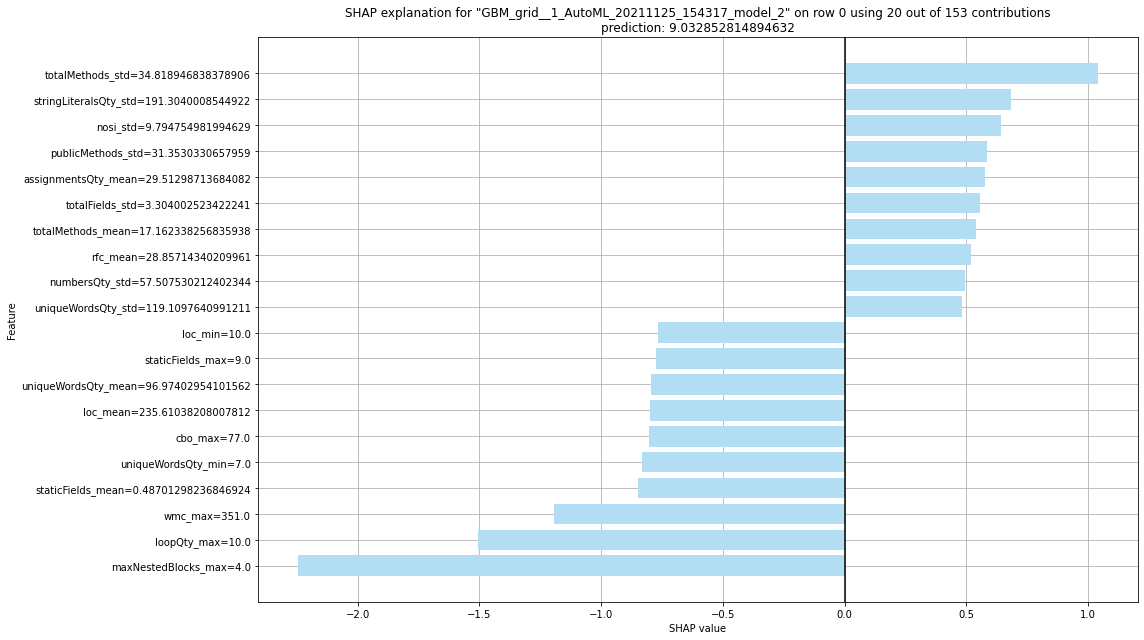

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

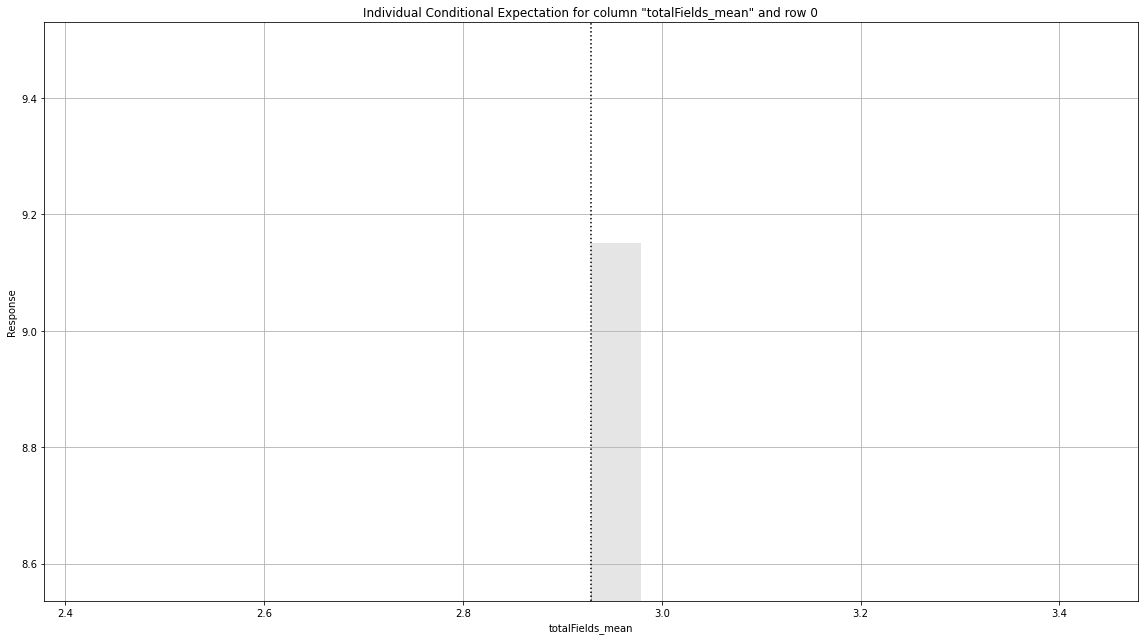

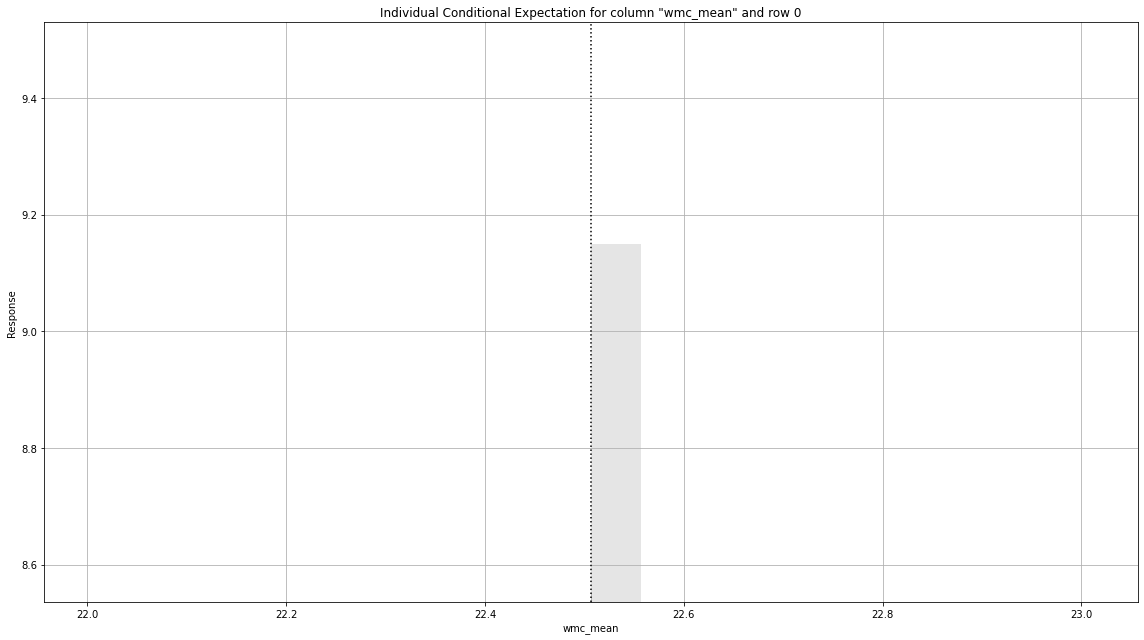

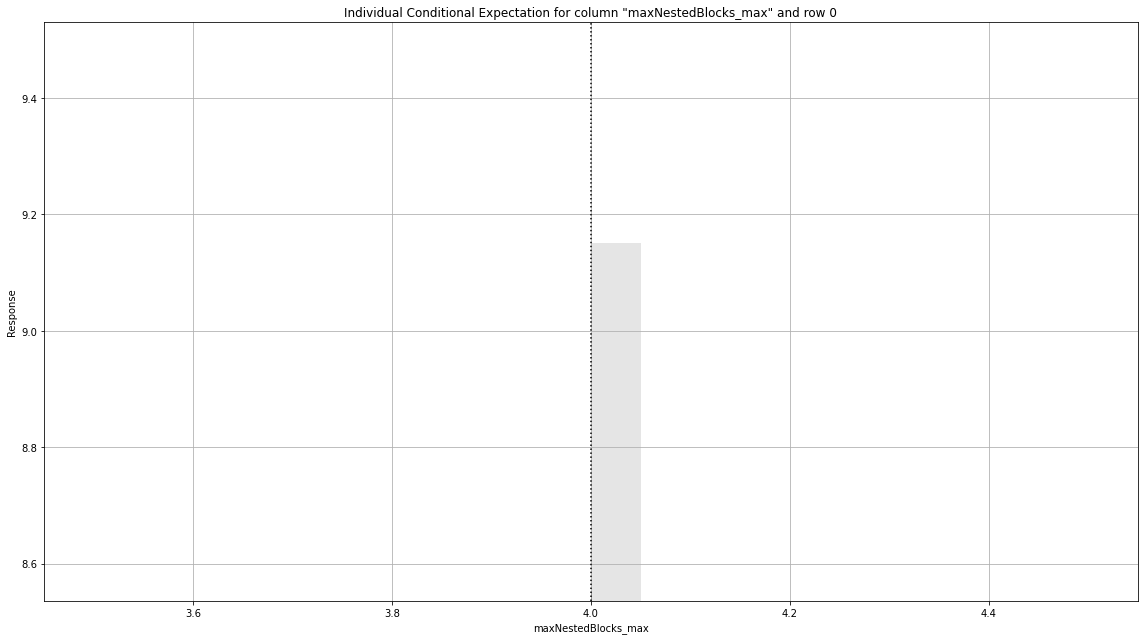

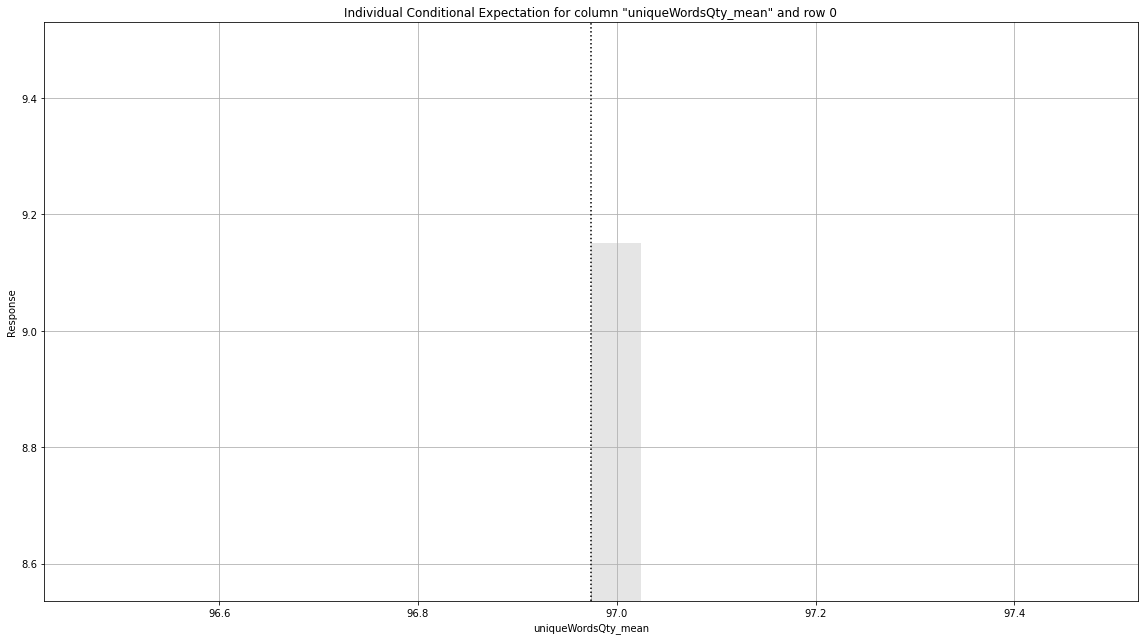

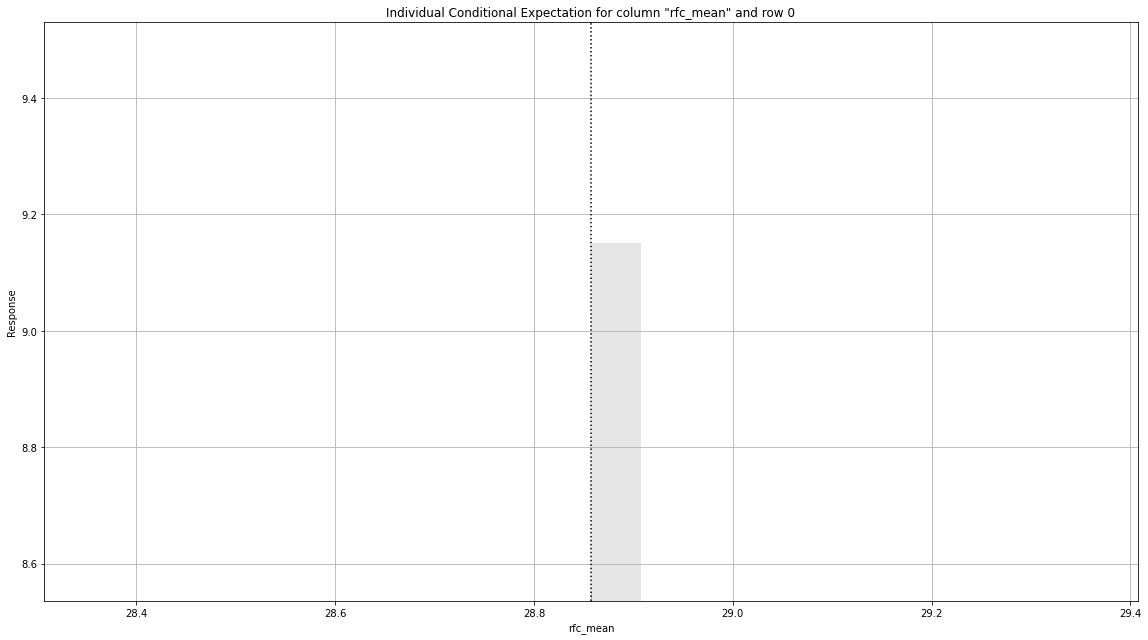

In [32]:
final_df = prediction_df
final_df['time_taken_final'] = preds[0]
exm = saved_model.explain_row(prediction_df, row_index=0)